In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
import random
import time
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch.nn.functional as F

import pickle

from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt

## Massage metric data into csv

In [2]:
# with open('tomtom_data_preprocessed_withadded.pkl','rb') as f:
#     [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
#     ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
#     tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f)

# kf = KFold(n_splits = 5, shuffle = True, random_state = 888) # make sure these parameters match up with what's used to train/test

# testinds = []
# for train, test in kf.split(list(range(tself_raw_noauto_3d.shape[0]))):
#     testinds.append(test)
    
# # print(testinds)


In [3]:
# # read in metrics and put them in a df
# maxk = 10

# allrows = []
# for k in range(maxk):  
#     with open('kfold_metrics_grp_k{}.pkl'.format(k+1),'rb') as f:
#         [ink] = pickle.load(f)
#         # each element in ink is results from a split
#         for split_id in range(len(ink)):
#             true_ids = testinds[split_id]
#             split = ink[split_id]
#             metric_list = [metric for metric in split]
#             [npar,nstimfrom,nstimto] = list(split[0].shape)
#             for participant in range(npar):
#                 for stimfrom in range(nstimfrom):
#                     for stimto in range(nstimto):
#                         pred_list = [metric[participant,stimfrom,stimto] for metric in split]
#                         [npredfrom, npredto] = list(pred_list[0].shape)
#                         for predfrom in range(npredfrom):
#                             for predto in range(npredto):
#                                 single_row = [k+1,true_ids[participant], stimfrom, stimto, predfrom,predto]
#                                 for i in range(len(pred_list)):
#                                     if i == (len(pred_list) - 1): # turns out MixtureSameFamily only returns the total log prob of evertying in the distribution object, so there's no by-item lp for soft (or dimensional)
#                                         single_row.append(pred_list[i].item()/(npredfrom*npredto)) #spread the total logprob across cells to make summing later easier
#                                     else:    
#                                         single_row.append(pred_list[i][predfrom,predto].item())
#                                 allrows.append(np.array(single_row))
#     del ink
                                
# allpred = np.stack(allrows,axis = 0)
# dfgrp = pd.DataFrame(allpred, columns = ['K','pid','stimfrom','stimto','predfrom','predto','h_ae','s_ae','h_se','s_se','h_lp','s_lpX'])
# dfgrp.to_csv('kfold_metrics_grp.csv',index = False)     

# # release memory 
# del allrows
                
        
        
    

In [4]:
# allrows = []
# maxk = 10
# for k in range(maxk):
#     for split_id in range(5):       
#         with open('kfold_metrics_dim_k{}_split{}.pkl'.format(k+1,split_id+1),'rb') as f:
#             [ink] = pickle.load(f)
#             true_ids = testinds[split_id]
#             split = list(ink)
#             split.pop(0)
#             metric_list = [metric for metric in split]
#             [npar,nstimfrom,nstimto] = list(split[0].shape)
#             for participant in range(npar):
#                 for stimfrom in range(nstimfrom):
#                     for stimto in range(nstimto):
#                         pred_list = [metric[participant,stimfrom,stimto] for metric in split]
#                         [npredfrom, npredto] = list(pred_list[0].shape)
#                         for predfrom in range(npredfrom):
#                             for predto in range(npredto):
#                                 single_row = [k+1,true_ids[participant], stimfrom, stimto, predfrom,predto]
#                                 for i in range(len(pred_list)):
#                                     if i == (len(pred_list) - 1): # turns out MixtureSameFamily only returns the total log prob of evertying in the distribution object, so there's no by-item lp for soft (or dimensional)
#                                         single_row.append(pred_list[i].item()/(npredfrom*npredto)) #spread the total logprob across cells to make summing later easier
#                                     else:    
#                                         single_row.append(pred_list[i][predfrom,predto].item())
#                                 allrows.append(np.array(single_row))
#     del ink                           
# allpred = np.stack(allrows,axis = 0)
# dfgrp = pd.DataFrame(allpred, columns = ['K','pid','stimfrom','stimto','predfrom','predto','d_ae','d_se','d_lpX'])
# dfgrp.to_csv('kfold_metrics_dim.csv',index = False) 

In [5]:
kfmtrc_grp = pd.read_csv('/scratch/gpfs/zidong/kfold_metrics_grp.csv')
kfmtrc_dim = pd.read_csv('/scratch/gpfs/zidong/kfold_metrics_dim.csv')

kfmtrc = kfmtrc_grp.merge(kfmtrc_dim, on = ['K', 'pid', 'stimfrom', 'stimto', 'predfrom', 'predto'])

## Plotting Raw data, all metrics against K

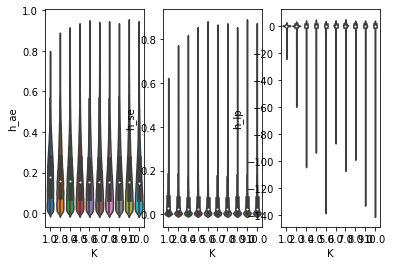

In [6]:
# hard group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kfmtrc, x = 'K',y = 'h_ae', ax=ax[0])
sns.violinplot(data = kfmtrc, x = 'K',y = 'h_se', ax=ax[1])
sns.violinplot(data = kfmtrc, x = 'K',y = 'h_lp', ax=ax[2])
fig.show()

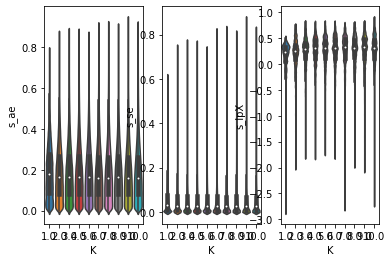

In [7]:
# soft group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kfmtrc, x = 'K',y = 's_ae', ax=ax[0])
sns.violinplot(data = kfmtrc, x = 'K',y = 's_se', ax=ax[1])
sns.violinplot(data = kfmtrc, x = 'K',y = 's_lpX', ax=ax[2])
fig.show()

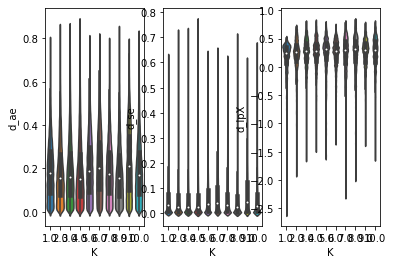

In [8]:
# dimension absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kfmtrc, x = 'K',y = 'd_ae', ax=ax[0])
sns.violinplot(data = kfmtrc, x = 'K',y = 'd_se', ax=ax[1])
sns.violinplot(data = kfmtrc, x = 'K',y = 'd_lpX', ax=ax[2])
fig.show()

## Aggregated at the participant level

highly skewed data on all metrics, use median instead of mean

In [9]:
kagg = kfmtrc.groupby(
    ['K','pid'],as_index= False
).aggregate(
    func = 'median'
)

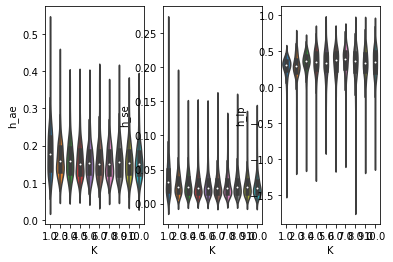

In [10]:
# hard group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kagg, x = 'K',y = 'h_ae', ax=ax[0])
sns.violinplot(data = kagg, x = 'K',y = 'h_se', ax=ax[1])
sns.violinplot(data = kagg, x = 'K',y = 'h_lp', ax=ax[2])
fig.show()

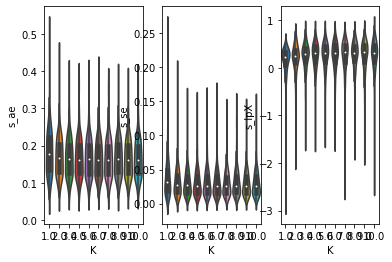

In [11]:
# soft group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kagg, x = 'K',y = 's_ae', ax=ax[0])
sns.violinplot(data = kagg, x = 'K',y = 's_se', ax=ax[1])
sns.violinplot(data = kagg, x = 'K',y = 's_lpX', ax=ax[2])
fig.show()

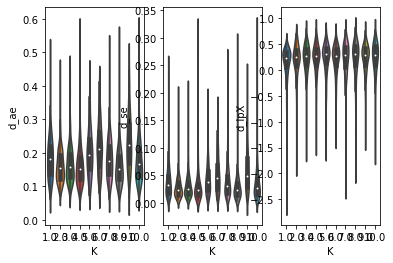

In [12]:
# dimension absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.violinplot(data = kagg, x = 'K',y = 'd_ae', ax=ax[0])
sns.violinplot(data = kagg, x = 'K',y = 'd_se', ax=ax[1])
sns.violinplot(data = kagg, x = 'K',y = 'd_lpX', ax=ax[2])
fig.show()

## Aggregated at K level

In [13]:
kaggagg = kfmtrc.groupby(
    ['K'],as_index= False
).aggregate(
    func = 'median'
)

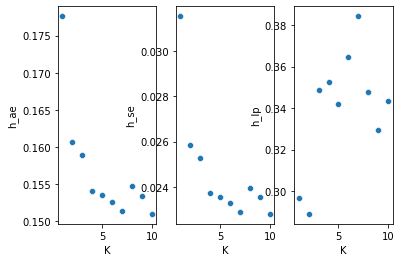

In [17]:
# hard group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.scatterplot(data = kaggagg, x = 'K',y = 'h_ae', ax=ax[0])
sns.scatterplot(data = kaggagg, x = 'K',y = 'h_se', ax=ax[1])
sns.scatterplot(data = kaggagg, x = 'K',y = 'h_lp', ax=ax[2])
fig.show()

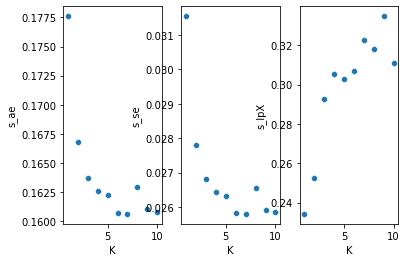

In [18]:
# soft group absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.scatterplot(data = kaggagg, x = 'K',y = 's_ae', ax=ax[0])
sns.scatterplot(data = kaggagg, x = 'K',y = 's_se', ax=ax[1])
sns.scatterplot(data = kaggagg, x = 'K',y = 's_lpX', ax=ax[2])
fig.show()

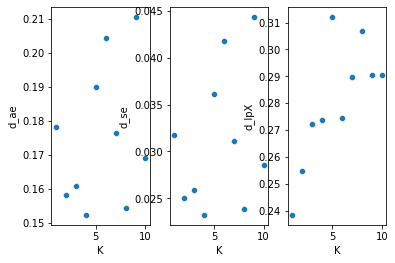

In [19]:
# dimension absolute, squared errors, and log probability
fig, ax =plt.subplots(1,3)
sns.scatterplot(data = kaggagg, x = 'K',y = 'd_ae', ax=ax[0])
sns.scatterplot(data = kaggagg, x = 'K',y = 'd_se', ax=ax[1])
sns.scatterplot(data = kaggagg, x = 'K',y = 'd_lpX', ax=ax[2])
fig.show()